In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import math
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd

In [60]:
def biased_agg(ratings):
    return (ratings.sum() + 3.5) / (len(ratings) + 3.5)

ratings = pd.read_csv('rating_archive/ratings_small.csv')
user_avg = ratings.groupby('userId', as_index=False)['rating'].agg(biased_agg)
movie_avg = ratings.groupby('movieId', as_index=False)['rating'].agg(biased_agg)
user_avg.columns = ['userId', 'user_avg']
movie_avg.columns = ['movieId', 'movie_avg']
user_cnt = ratings.groupby('userId', as_index=False)['rating'].count()
user_cnt.columns = ['userId', 'user_cnt']

In [61]:
avg_est = ratings.merge(movie_avg, on='movieId', how='left')
avg_est = avg_est[['userId', 'movieId', 'rating', 'movie_avg']]
avg_est.columns = ['userId', 'movieId', 'rating', 'rating_est']

In [107]:
print(user_percentile_diff([1, 2, 3, 4, 5, 6, 7], [1, 2, 3, 4, 5, 6, 7]))

0.0


In [62]:
def user_percentile_diff(user_ratings, user_est):   
    user_ranking = np.argsort(user_ratings)
    est_ranking = np.argsort(user_est)
    ranking_diff = np.abs(user_ranking - est_ranking)
    perc_diff = (ranking_diff / len(user_ratings)).mean()
    return perc_diff

# r = [1, 2, 3, 4, 5]
# r_est = [2, 1, 3, 6, 5]
# print(user_percentile_diff(r, r_est))

# user_perc_diff = avg_est.groupby('userId', as_index=False).apply(lambda x: user_percentile_diff(x['rating'], x['rating_est']))
# print(user_perc_diff.iloc[:, 1].mean())

def mean_percentile_diff(pred_mat):
    user_perc_diff = pred_mat.groupby('userId', as_index=False).apply(lambda x: user_percentile_diff(x['rating'], x['rating_est']))
    return user_perc_diff.iloc[:, 1].mean()

In [108]:
row_shuffle = np.arange(len(ratings))
np.random.shuffle(row_shuffle)
train_ratings = ratings.iloc[row_shuffle[:len(ratings)*5 // 6]]
test_ratings = ratings.iloc[row_shuffle[len(ratings)*5 // 6:]]

In [109]:
class RatingDataset(Dataset):
    def __init__(self, ratings):
        super().__init__()
        self.ratings = ratings[['userId', 'movieId', 'rating']]
    
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        rind = torch.LongTensor(self.ratings.iloc[idx, :2].values)
        rval = torch.FloatTensor(self.ratings.iloc[idx, 2:].values)
        return rind, rval

In [110]:
user_ids = ratings['userId'].unique()
movie_ids = ratings['movieId'].unique()
MAX_USER, MAX_MOVIE = max(user_ids), max(movie_ids)

In [123]:
class LRMat(nn.Module):
    def __init__(self, num_users, num_movies, rank=4):
        super().__init__()
        self.user_emb = nn.Parameter(torch.normal(torch.zeros(num_users, rank), 1/np.sqrt(rank)))
        self.user_bias = nn.Parameter(torch.zeros((num_users,))+3.5)
        self.movie_emb = nn.Parameter(torch.normal(torch.zeros(num_movies, rank), 1/np.sqrt(rank)))
        self.user_sigmoid = nn.Parameter(torch.ones(num_users))

    def forward(self, user_id, movie_id):
        sig_mult = self.user_sigmoid[user_id]
        return (sig_mult*torch.sigmoid((self.user_emb[user_id] * self.movie_emb[movie_id]).sum(dim=1))
                + self.user_bias[user_id]
                ).reshape(-1, 1)

lr_mat = LRMat(MAX_USER+1, MAX_MOVIE+1, rank=4)

In [124]:
train_ratings_ds = RatingDataset(train_ratings)
train_ratings_dl = DataLoader(train_ratings_ds, batch_size=4096, shuffle=True)

test_ratings_ds = RatingDataset(test_ratings)
test_ratings_dl = DataLoader(test_ratings_ds, batch_size=4096, shuffle=True)

In [130]:
optimizer = optim.Adam(lr_mat.parameters(), lr=0.01)

def train(lr_mat, optimizer, dl, epochs=10):
    for epoch in range(epochs):
        train_loss = 0
        for rind, rval in dl:
            optimizer.zero_grad()
            pred = lr_mat(rind[:, 0], rind[:, 1])
            loss = (F.mse_loss(pred, rval) 
                    + 0.01*torch.mean(torch.square(lr_mat.user_emb[rind[:, 0], :]))
                    + 0.01*torch.mean(torch.square(lr_mat.movie_emb[rind[:, 1], :]))
                    )
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(train_loss / len(dl))
train(lr_mat, optimizer, train_ratings_dl, epochs=25)

0.592835179397038
0.5822281383332752
0.5721745519410997
0.5661666677111671
0.5590193158104306
0.5525707829566229
0.5479350742839632
0.5447905716441926
0.5376668685958499
0.5342695344062078
0.5296319552830288
0.523982489392871
0.5212271071615673
0.5187831478459495
0.5152136428015572
0.5117603299163637
0.5079910840306964
0.506066871540887
0.5047323746340615
0.5006305036090669
0.4985495408376058
0.49576135192598614
0.49437838934716727
0.4929093278589703
0.49176596601804096


In [131]:
def PCA(X):
    X -= X.mean(axis=0, keepdims=True)
    U, S, V = np.linalg.svd(X, full_matrices=False)
    print(U.shape, S, V.shape)
    return U
pca_ld = PCA(lr_mat.movie_emb.detach().numpy())[:, :2]

(163950, 4) [221.64856 214.42903 211.24196 211.16878] (4, 4)


In [128]:
import matplotlib.pyplot
# plt.hist(lr_mat.user_bias.detach().numpy(), bins=55)
# plt.show()

# plt.scatter(pca_ld[:, 0], pca_ld[:, 1], s=2)
# plt.show()

In [132]:
rid = torch.LongTensor(train_ratings[['userId', 'movieId']].values)
lr_pred = lr_mat(rid[:, 0], rid[:, 1]).detach().numpy().flatten()

lr_est = pd.DataFrame({'userId': train_ratings['userId'], 'movieId': train_ratings['movieId'], 'rating': train_ratings['rating'], 'rating_est': lr_pred})

print(mean_percentile_diff(lr_est))
print(mean_percentile_diff(avg_est))

print(np.mean((lr_est['rating_est'] - lr_est['rating'])**2))
print(np.mean((avg_est['rating_est'] - avg_est['rating'])**2))

0.32425197340455303
0.3236506247827002
0.463552729342977
1.1512247932659359


In [133]:
rid = torch.LongTensor(test_ratings[['userId', 'movieId']].values)
lr_pred = lr_mat(rid[:, 0], rid[:, 1]).detach().numpy().flatten()

lr_est = pd.DataFrame({'userId': test_ratings['userId'], 'movieId': test_ratings['movieId'], 'rating': test_ratings['rating'], 'rating_est': lr_pred})

print(mean_percentile_diff(lr_est))
print(mean_percentile_diff(avg_est))

print(np.mean((lr_est['rating_est'] - lr_est['rating'])**2))
print(np.mean((avg_est['rating_est'] - avg_est['rating'])**2))

0.31113743608622085
0.3236506247827002
0.9144257964594014
1.1512247932659359


In [134]:
for i in range(100, 110):
    a = lr_est[lr_est['userId'] == i]
    e1 = np.mean((a['rating_est'] - a['rating'])**2)

    a = avg_est[avg_est['userId'] == i]
    e2 = np.mean((a['rating_est'] - a['rating'])**2)
    print(e1, e2)

0.058019466363077754 0.3193607552413445
0.26395742511115117 0.5071496165149155
0.7545763326105124 1.1121211604992467
0.27247821562174274 0.7769999336064296
0.18978811686477887 0.621338364749099
0.2613436877166579 0.503707216921867
0.6197152971836223 2.1183810922134465
1.143551195529572 1.2999622021003043
0.9781920595996212 0.889135934966136
0.3122245970307726 0.6838220488002625


In [22]:
print(lr_est[lr_est['userId'] == 2], '\n\n')
print(avg_est[avg_est['userId'] == 2])

    userId  movieId  rating  rating_est
20       2       10     4.0    3.769511
21       2       17     5.0    3.507967
22       2       39     5.0    3.689283
23       2       47     4.0    3.451399
24       2       50     4.0    3.491221
..     ...      ...     ...         ...
91       2      592     5.0    3.502338
92       2      593     3.0    3.421246
93       2      616     3.0    3.507885
94       2      661     4.0    3.515223
95       2      720     4.0    3.630857

[76 rows x 4 columns] 


    userId  movieId  rating  rating_est
20       2       10     4.0    3.382470
21       2       17     5.0    3.810056
22       2       39     5.0    3.477733
23       2       47     4.0    3.982885
24       2       50     4.0    4.312958
..     ...      ...     ...         ...
91       2      592     5.0    3.355890
92       2      593     3.0    4.102439
93       2      616     3.0    3.274725
94       2      661     4.0    3.469027
95       2      720     4.0    3.783505

[76 rows x 4 

In [ ]:
# ratings, ratings_est: dataframes with userid, movieid, and rating columns

(array([ 105.,  330.,  368., 1003., 1393.,  661.,  887.,  694.,  574.,
         523.,  472.,  437.,  431.,  331.,  334.,  228.,  182.,   77.,
          32.,    4.]),
 array([0.76923077, 0.95318576, 1.13714076, 1.32109576, 1.50505075,
        1.68900575, 1.87296074, 2.05691574, 2.24087073, 2.42482573,
        2.60878073, 2.79273572, 2.97669072, 3.16064571, 3.34460071,
        3.52855571, 3.7125107 , 3.8964657 , 4.08042069, 4.26437569,
        4.44833068]),
 <BarContainer object of 20 artists>)

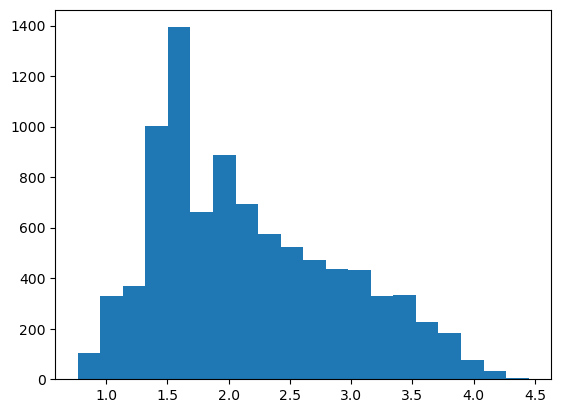

In [34]:
plt.hist(movie_avg['movie_avg'], bins=20)

In [30]:
movies_metadata = pd.read_csv('rating_archive/movies_metadata.csv')
movies_metadata = movies_metadata[['id', 'title', 'genres']]

/tmp/ipykernel_4980/2584923186.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_metadata = pd.read_csv('rating_archive/movies_metadata.csv')


In [31]:
# Goal is to assign a score to each movie which correctly reproduces user rankings. Accuracy for scores is 
# based on the number of misranked movies for each user. 

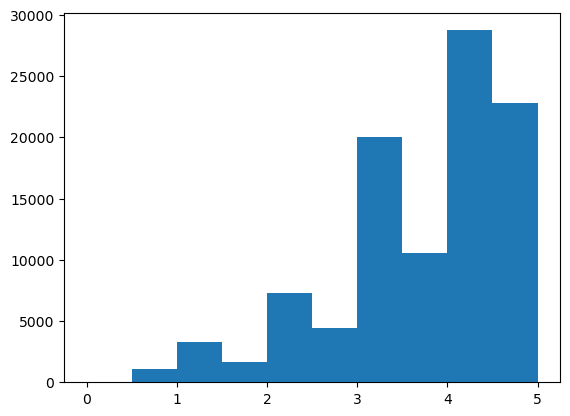

In [11]:
plt.hist(ratings['rating'], bins=np.linspace(0, 5, 11))
plt.show()

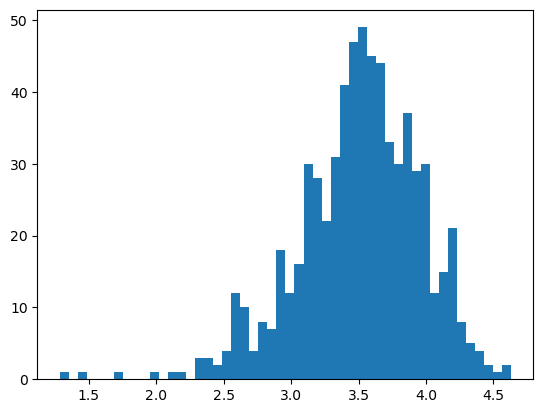

In [16]:
plt.hist(user_avg['user_avg'], bins=50)
plt.show()